In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
import cv2
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [2]:
# reading captions
def readTxtFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTxtFile('./Flickr_TextData/Flickr8k.token.txt')
captions = captions.split('\n')
captions = captions[:-1] # slicing as last line as it is empty
print(captions[0])
print(len(captions))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
40460


In [4]:
# The format in which the captions are stored is img_id #caption_num caption. 
# Therefore we will create a mapping between captions in the list to its corresponding image.
descriptions = {}
for caption in captions:
    first,second = caption.split('\t') # Splitting the caption wrt '\t'
    image = first.split('.')[0]
    
    if descriptions.get(image) is None:
        descriptions[image] = []
    descriptions[image].append(second)

In [5]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

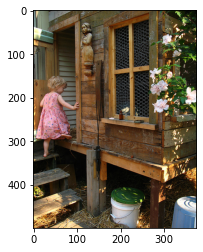

In [6]:
# Image to the corresponding description.
IMG_PATH = './Images/'
img = cv2.imread(IMG_PATH + "1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

## Cleaning captions
1. Converting to lower case.
2. Removing numbers.
3. Removing puntuations.

We will not remove stopwords and will not lemmatize text as we want proper sentences as our output

In [7]:
# A function which will recieve sentence as an input and will return a clean_text.
def cleanText(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence) # Replacing which which are not formed by alphabets with a space
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1] # removing word which has length 1
    sentence = " ".join(sentence) 
    return sentence

In [8]:
# Cleaning all the captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = cleanText(caption_list[i])

In [9]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [10]:
# As we may have to use the same data. We are going to store the above cleaned data to a text file
with open("description.txt",'w') as f:
    f.write(str(descriptions))

## Creating vocab
1. Store all the unique word in form of dict.
2. We will discard words which will have a freq less than a threshold frequency.


 This will reduce our size of vocab. 

In [11]:
descriptions = None
with open("./description.txt",'r') as f:
    descriptions = f.read()
    
#Converting descriptions frrom string to dictionary
json_accepted = descriptions.replace("'","\"")
descriptions = json.loads(json_accepted)
print(type(descriptions))

<class 'dict'>


In [12]:
# Vocab 
vocab = set()

for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

total_words = []

print("Vocab Size is: %d"%len(vocab)) 

for key in descriptions.keys():
    for sentence in descriptions[key]:
        for i in sentence.split():
            total_words.append(i)
            
print("Total Words: %d"%len(total_words))

# Datastructure to count the frequency of the words in all words
import collections
counter = collections.Counter(total_words)
freq_count = dict(counter)
sorted_freq_count = sorted(freq_count.items(),reverse=True,key = lambda x: x[1])

#filtering the vocab
threshold = 10

sorted_freq_count = [x for x in sorted_freq_count if x[1] > threshold]
total_words = [x[0] for x in sorted_freq_count]
print("Total Words after filtering: %d"%len(total_words))

Vocab Size is: 8424
Total Words: 373837
Total Words after filtering: 1845


## Preparing training and testing data

Format of data is as follows
1. All the images are in single folder "Images"
2. Captions are stored in the text file with corresponding image_name
3. Data is divided into train and test.
4. train.txt and text.txt contain image ids .


In [13]:
# reading the training and testing data
training_file_data = readTxtFile("./Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTxtFile("./Flickr_TextData/Flickr_8k.testImages.txt")

train = [row.split(".")[0] for row in training_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]


# creating the dictionary for training data
train_description = {}

# attaching startseq and endseq with each caption to prepare training data
for image_id in train:
    train_description[image_id] = []
    for caption in descriptions[image_id]:
        caption = "startseq " + caption + " endseq"  
        train_description[image_id].append(caption)
        
print(train_description["1000268201_693b08cb0e"])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


## Image preprocessing

1. For freature extraction of image we have use ResNet50 trained on imagenet dataset with skip connections

In [14]:
# Model creation
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
# we will use the output from the Global Average Pooling layer of the ResNet50
model_new = Model(model.input,model.layers[-2].output)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


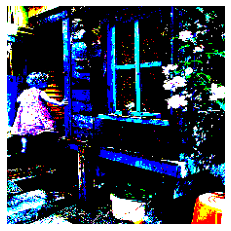

In [16]:
#Image pre-processing
from keras.preprocessing import image
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    # As the input to a ResNet is a 4D tensor.Therefore expanding the size (1,224,224,3)
    img = np.expand_dims(img,axis=0) 
     #Normalisation
    img = preprocess_input(img)    
    return img

img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()


In [17]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [18]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06535936, 0.16782555, 0.32517606, ..., 0.05107125, 0.32821214,
       1.0043374 ], dtype=float32)

In [19]:
#Encoding every image in the training dataset ie. extracting context vector from the ResNet for the training data.
encoding_train = {}
start = time()
for ix,img_id in enumerate(train):
    img_path = IMG_PATH + img_id + ".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100 == 0:
        print("Progress of encoding timestep %d"%ix)
        
end = time()
print("Total time taken %f" %(end-start))


Progress of encoding timestep 0
Progress of encoding timestep 100
Progress of encoding timestep 200
Progress of encoding timestep 300
Progress of encoding timestep 400
Progress of encoding timestep 500
Progress of encoding timestep 600
Progress of encoding timestep 700
Progress of encoding timestep 800
Progress of encoding timestep 900
Progress of encoding timestep 1000
Progress of encoding timestep 1100
Progress of encoding timestep 1200
Progress of encoding timestep 1300
Progress of encoding timestep 1400
Progress of encoding timestep 1500
Progress of encoding timestep 1600
Progress of encoding timestep 1700
Progress of encoding timestep 1800
Progress of encoding timestep 1900
Progress of encoding timestep 2000
Progress of encoding timestep 2100
Progress of encoding timestep 2200
Progress of encoding timestep 2300
Progress of encoding timestep 2400
Progress of encoding timestep 2500
Progress of encoding timestep 2600
Progress of encoding timestep 2700
Progress of encoding timestep 28

In [20]:
# Encoding every test image. ie extracting context vector from the ResNet50 for testing purpose
encoding_test = {}
start = time()
for ix,img_id in enumerate(test):
    img_path = IMG_PATH + img_id + ".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100 == 0:
        print("Progress of encoding timestep %d"%ix)
        
end = time()
print("Total time taken %f" %(end-start))

Progress of encoding timestep 0
Progress of encoding timestep 100
Progress of encoding timestep 200
Progress of encoding timestep 300
Progress of encoding timestep 400
Progress of encoding timestep 500
Progress of encoding timestep 600
Progress of encoding timestep 700
Progress of encoding timestep 800
Progress of encoding timestep 900
Total time taken 398.952918


In [21]:
!mkdir saved


mkdir: cannot create directory ‘saved’: File exists


In [22]:
with open("saved/encoding_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [23]:
with open("saved/encoding_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

## Data preprocessing for captions
1. Making dictionaries for word to index and for index to words

In [24]:
word_to_index = {}
index_to_word = {}

for i,word in enumerate(total_words):
    # 0th index is reserved for the words which are not present in out vocab.
    word_to_index[word] = i+1
    index_to_word[i+1] = word

# Adding two additional words 
index_to_word[1846] = "startseq"
word_to_index["startseq"] = 1846
index_to_word[1847] = "endseq"
word_to_index["endseq"] = 1847

vocab_size = len(word_to_index) + 1

In [25]:
# Now we will find the maximum length of the caption. As this will be one of the dimension of the input.

max_len = 0
for key in train_description.keys():
    for caption in train_description[key]:
        max_len = max(max_len,len(caption.split()))

print(max_len)

35


In [26]:
with open("saved/word_to_index.pkl","wb") as f:
    pickle.dump(word_to_index,f)

with open("saved/index_to_word.pkl","wb") as f:
    pickle.dump(index_to_word,f)

## Data Generator
1. We will train our model where data is feeded in batch.

In [27]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    n = 0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n == batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0

## Using glove embedding to embedd captions

In [28]:
f = open("./glove.6B.50d.txt",encoding='utf8')
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

f.close()

print(embedding_index["abs"])

[-0.66695  -1.1015    0.92495   0.58853  -0.84646  -0.47339   0.30835
 -0.97431   0.28447  -0.3069    1.266     0.19545  -0.32885   0.79057
 -0.10433   0.75212  -1.0128    0.85332   0.93304  -0.17997  -0.17619
  0.51202   0.66801   0.53482  -0.12115   0.24547  -0.69114   0.91041
 -0.70587  -0.048063  1.4628    0.76462   0.64772   0.79057  -0.19362
  0.9545    0.32447  -0.88816   0.95408  -0.039135  0.30109   1.0442
 -0.45311  -0.45743  -0.79809  -0.9363    0.22308   0.77853   1.2766
 -0.0409  ]


In [29]:
#we will create our embedding matrix with words which are present in out vocab

def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_index.items():
        embedding_vec = embedding_index.get(word)
        if embedding_vec is not None:
            matrix[idx] = embedding_vec
    return matrix

In [30]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


## Model Architecture

In [31]:
# Taking image inputs
input_img_feature = Input(shape = (2048,))
inp_img1 = Dropout(0.3)(input_img_feature)
inp_img2 = Dense(256,activation = 'relu')(inp_img1)

#Taking Caption input

input_captions = Input(shape = (max_len,))
inp_cap1 = Embedding(input_dim = vocab_size,output_dim = 50,mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
outputs = Dense(vocab_size,activation = 'softmax')(decoder2)

# Combining models

model = Model(inputs = [input_img_feature,input_captions],outputs = outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [32]:
# Pre-Initialization of embedding_layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy',optimizer= 'adam')

## Model Training

In [33]:
!mkdir model_weights

mkdir: cannot create directory ‘model_weights’: File exists


In [34]:
epochs = 20
batch_size = 3
steps = len(train_description)//batch_size

def train():
    for i in range(epochs):
        generator = data_generator(train_description,encoding_train,word_to_index,max_len,batch_size)
        model.fit_generator(generator,epochs=1, steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')


In [35]:
model = load_model('./model_weights/model_9.h5')

In [36]:
# Predicting output
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence],maxlen = max_len,padding='post')
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #greedy sampling of the words.
        word = index_to_word[ypred]
        in_text += ' ' + word
        
        if word == "endseq":
            break
    final_caption = in_text.split()[1:-1] # Removing startseq and endseq from the captions
    final_caption = ' '.join(final_caption)
    return final_caption

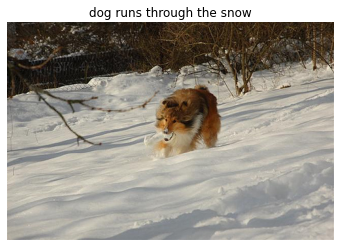

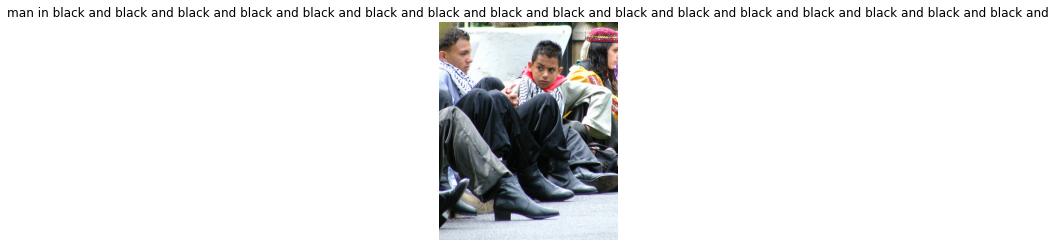

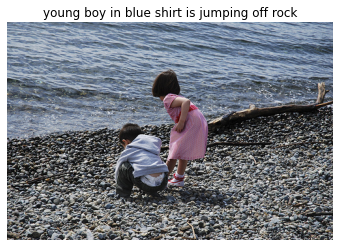

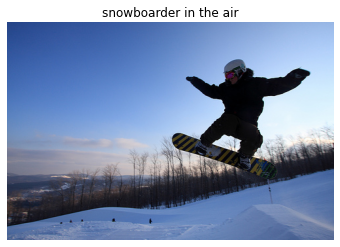

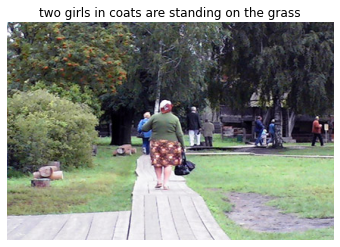

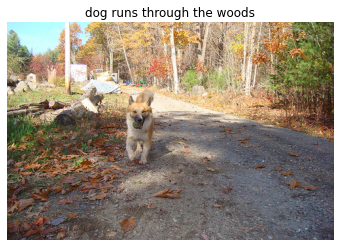

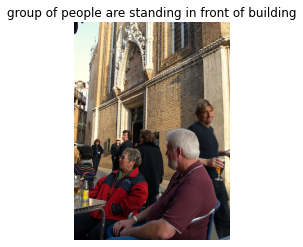

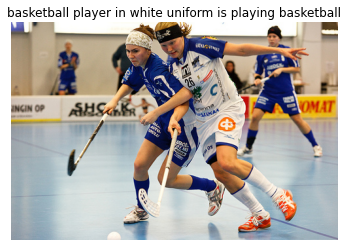

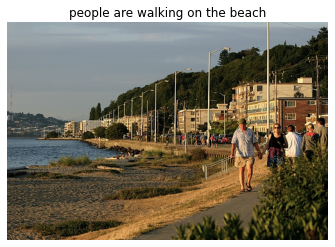

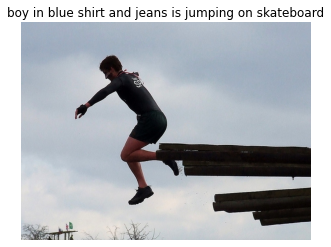

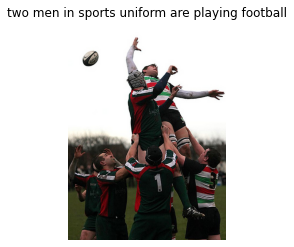

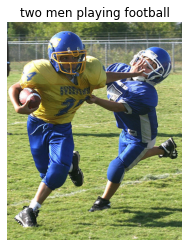

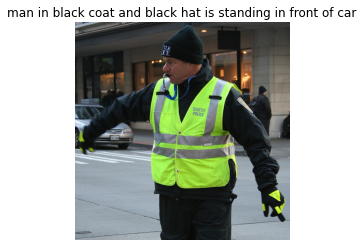

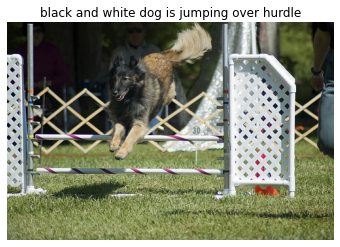

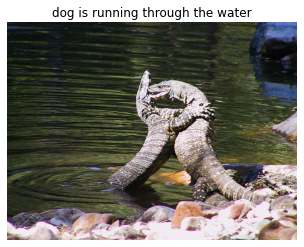

In [37]:
# Picking random images and seeing result

for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    i = plt.imread(IMG_PATH+img_name+".jpg")
    caption = predict_caption(photo_2048)
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()